In [1]:
!pip install dython

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
import optuna
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from dython.nominal import associations
from IPython.display import display

In [2]:
df_train = pd.read_csv("/kaggle/input/playground-series-s4e9/train.csv", index_col="id")
df_test = pd.read_csv("/kaggle/input/playground-series-s4e9/test.csv", index_col="id")

In [3]:
df_train.head(3)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900


In [4]:
df_test.head(3)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
id,,,,,,,,,,,
188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN


In [5]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types and Info #####################")
    print(dataframe.dtypes)
    print(dataframe.info())
    print("Duplicated Rows:",dataframe.duplicated().sum())
check_df(df_train)

##################### Shape #####################
(188533, 12)
##################### Types and Info #####################
brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price            int64
dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   acci

In [6]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
model_year,188533.0,2015.829998,5.660967,1974.0,2013.0,2017.0,2020.0,2024.0
milage,188533.0,65705.295174,49798.158076,100.0,24115.0,57785.0,95400.0,405000.0
price,188533.0,43878.016178,78819.522254,2000.0,17000.0,30825.0,49900.0,2954083.0


In [7]:
def analyse_data(df,cols):
    d = pd.DataFrame()
    cl = [];u = [];s =[]; nans =[];share=[]
    for c in cols:
        cl.append(c); u.append(df[c].unique());s.append(df[c].unique().size);nans.append(df[c].isnull().sum());share.append(round((df[c].isnull().sum()/len(df))*100,2))
    d['Column'] = cl;d["Uniques"] = u; d["frequency"] = s; d["Nans"] = nans; d["ShareOfNans"]= share
    return d


analyse_data(df_train,df_train.columns)

,Column,Uniques,frequency,Nans,ShareOfNans
0,brand,"[MINI, Lincoln, Chevrolet, Genesis, Mercedes-B...",57,0,0.00
1,model,"[Cooper S Base, LS V8, Silverado 2500 LT, G90 ...",1897,0,0.00
2,model_year,"[2007, 2002, 2017, 2021, 2018, 2016, 2020, 201...",34,0,0.00
3,milage,"[213000, 143250, 136731, 19500, 7388, 40950, 6...",6651,0,0.00
4,fuel_type,"[Gasoline, E85 Flex Fuel, nan, Hybrid, Diesel,...",8,5083,2.70
5,engine,"[172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,...",1117,0,0.00
6,transmission,"[A/T, Transmission w/Dual Shift Mode, 7-Speed ...",52,0,0.00
7,ext_col,"[Yellow, Silver, Blue, Black, White, Snowflake...",319,0,0.00
8,int_col,"[Gray, Beige, Black, –, Blue, White, Red, Brow...",156,0,0.00
9,accident,"[None reported, At least 1 accident or damage ...",3,2452,1.30


In [8]:
analyse_data(df_test,df_test.columns)

,Column,Uniques,frequency,Nans,ShareOfNans
0,brand,"[Land, Ford, Audi, Chevrolet, Lexus, Mercedes-...",55,0,0.00
1,model,"[Rover LR2 Base, Rover Defender SE, Expedition...",1891,0,0.00
2,model_year,"[2015, 2020, 2022, 2016, 2018, 2013, 2008, 201...",36,0,0.00
3,milage,"[98000, 9142, 28121, 61258, 59000, 99524, 1940...",5700,0,0.00
4,fuel_type,"[Gasoline, Hybrid, Diesel, E85 Flex Fuel, nan,...",8,3383,2.69
5,engine,"[240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,...",1117,0,0.00
6,transmission,"[6-Speed A/T, 8-Speed A/T, 10-Speed Automatic,...",52,0,0.00
7,ext_col,"[White, Silver, Silician Yellow, Gray, Black, ...",317,0,0.00
8,int_col,"[Beige, Black, Ebony, Gray, Jet Black, –, Red,...",156,0,0.00
9,accident,"[None reported, At least 1 accident or damage ...",3,1632,1.30


In [9]:
target = 'price'
cat_cols = df_train.drop(target, axis=1).select_dtypes(include='object').columns.to_list()
num_cols = df_train.drop(target, axis=1).select_dtypes(exclude='object').columns.to_list()

print("Categorical Columns:", cat_cols, "\n\nNumerical Columns:", num_cols)

Categorical Columns: ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title'] 

Numerical Columns: ['model_year', 'milage']


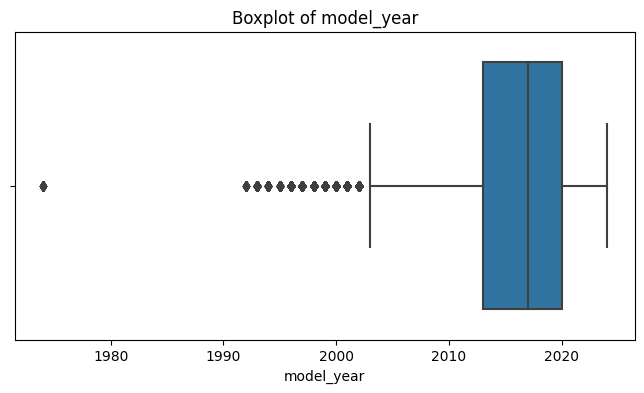

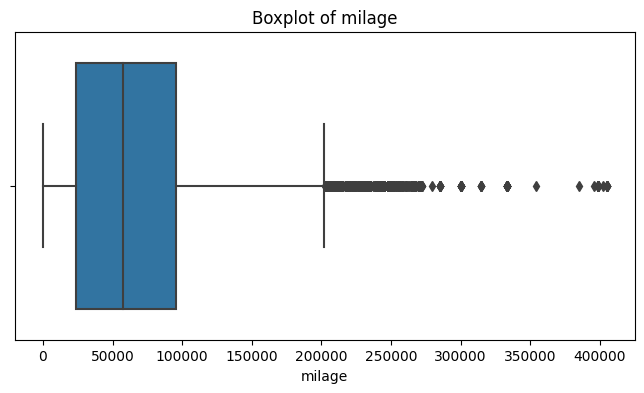

In [10]:
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df_train[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


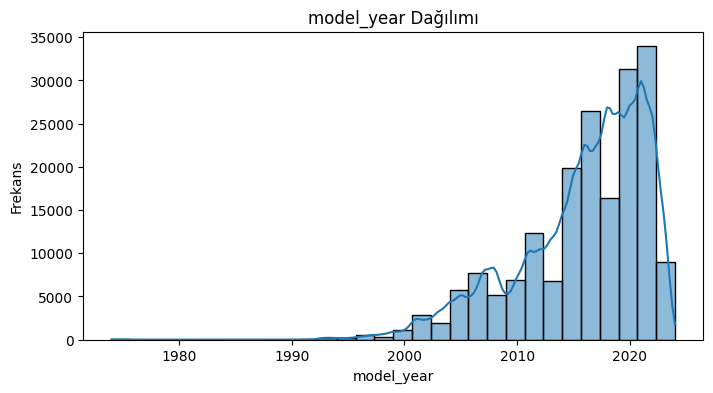

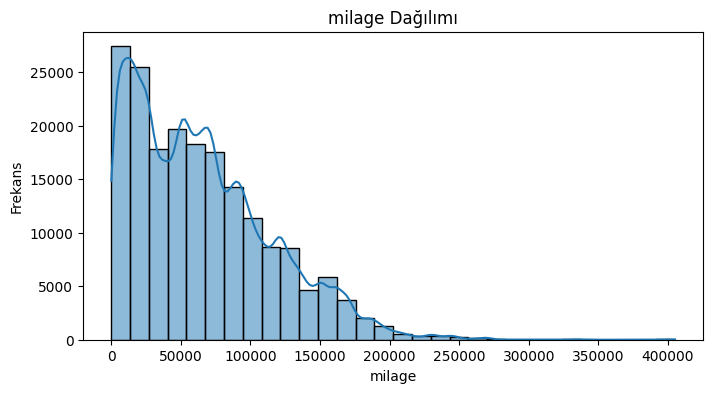

In [11]:
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_train[col], kde=True, bins=30)
    plt.title(f"{col} Dağılımı")
    plt.xlabel(col)
    plt.ylabel('Frekans')
    plt.show()

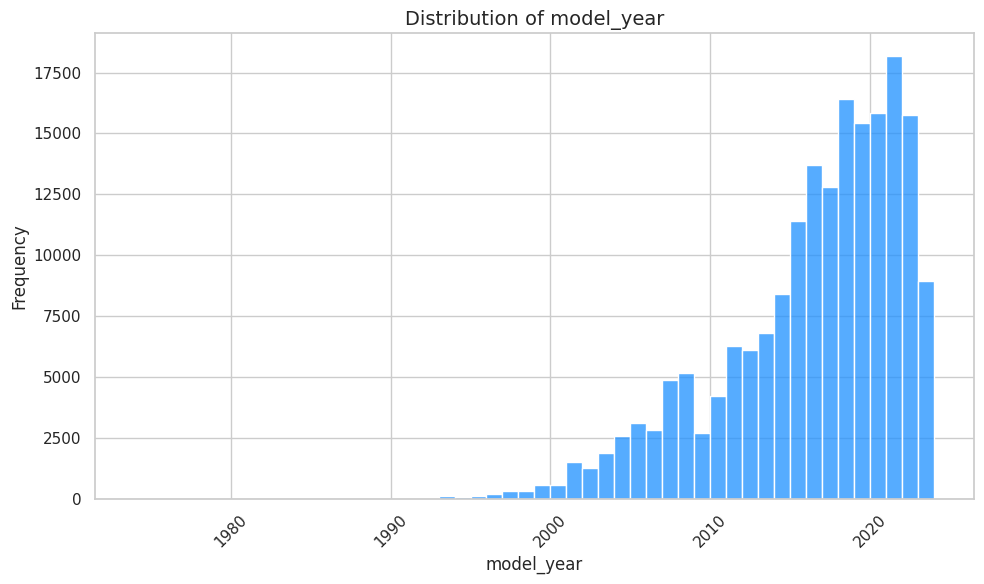

Column: model_year
Number of unique values: 34
Missing values: 0 (0.00%)




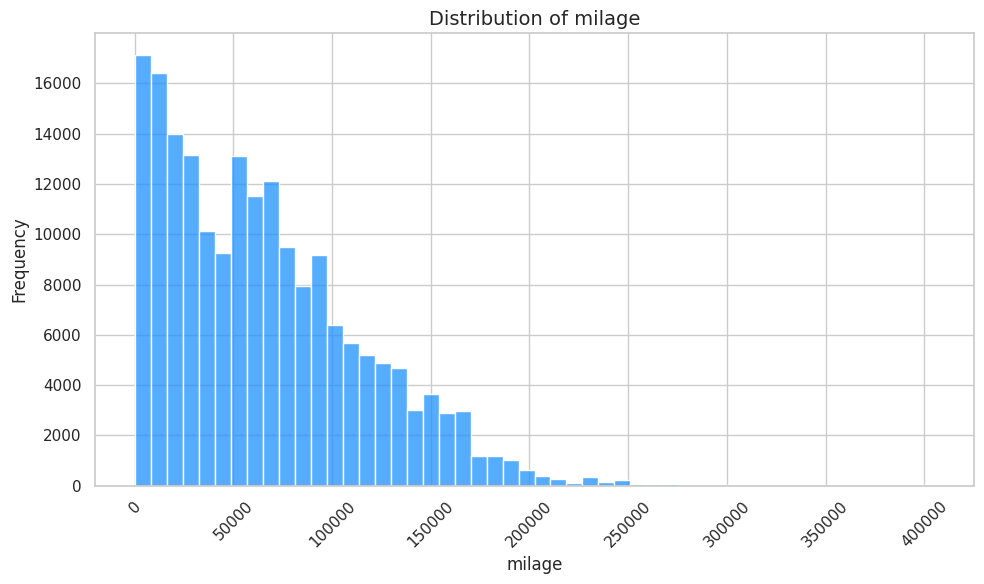

Column: milage
Number of unique values: 6651
Missing values: 0 (0.00%)




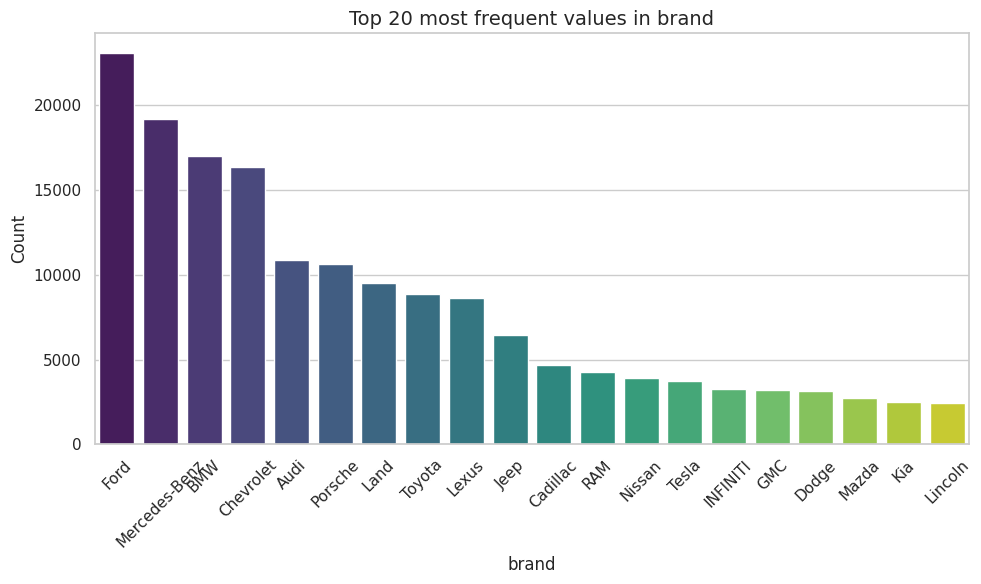

Column: brand
brand
Ford             23088
Mercedes-Benz    19172
BMW              17028
Chevrolet        16335
Audi             10887
Porsche          10612
Land              9525
Toyota            8850
Lexus             8643
Jeep              6474
Cadillac          4674
RAM               4249
Nissan            3930
Tesla             3738
INFINITI          3276
GMC               3215
Dodge             3133
Mazda             2719
Kia               2497
Lincoln           2423
Name: count, dtype: int64

Missing values: 0 (0.00%)




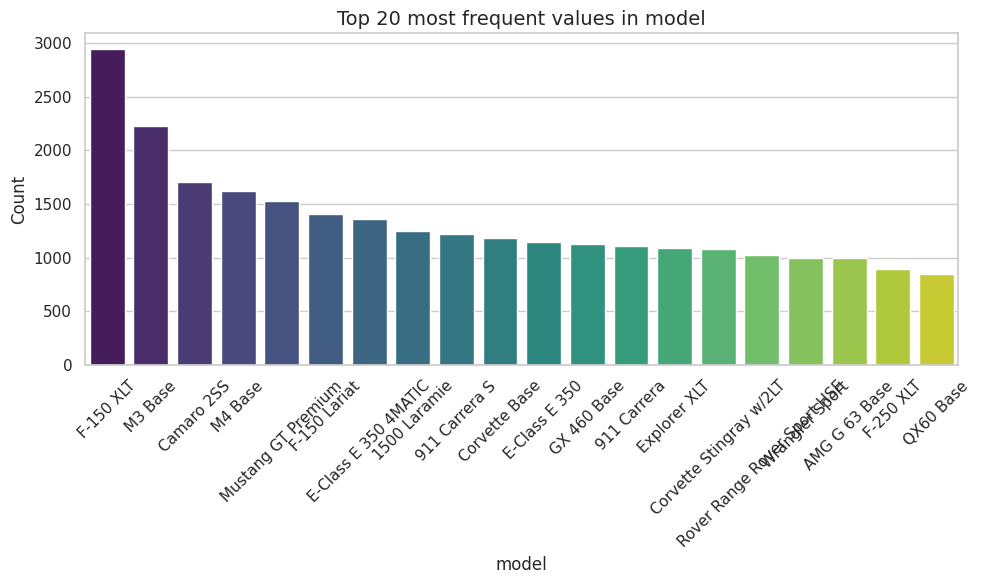

Column: model
model
F-150 XLT                      2945
M3 Base                        2229
Camaro 2SS                     1709
M4 Base                        1622
Mustang GT Premium             1526
F-150 Lariat                   1410
E-Class E 350 4MATIC           1357
1500 Laramie                   1249
911 Carrera S                  1219
Corvette Base                  1184
E-Class E 350                  1148
GX 460 Base                    1124
911 Carrera                    1111
Explorer XLT                   1091
Corvette Stingray w/2LT        1081
Rover Range Rover Sport HSE    1027
Wrangler Sport                 1001
AMG G 63 Base                   994
F-250 XLT                       893
QX60 Base                       847
Name: count, dtype: int64

Missing values: 0 (0.00%)




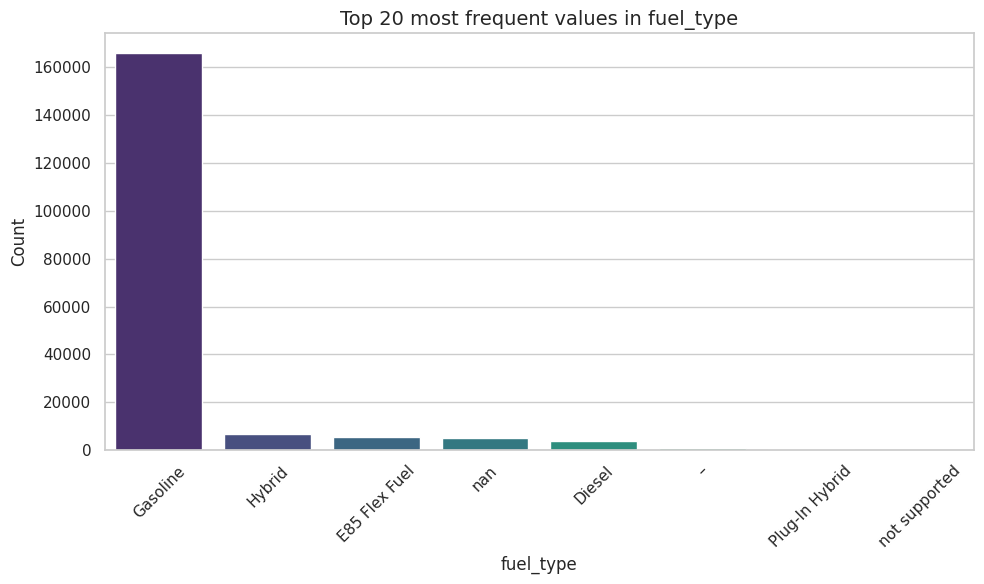

Column: fuel_type
fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
NaN                 5083
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64

Missing values: 5083 (2.70%)




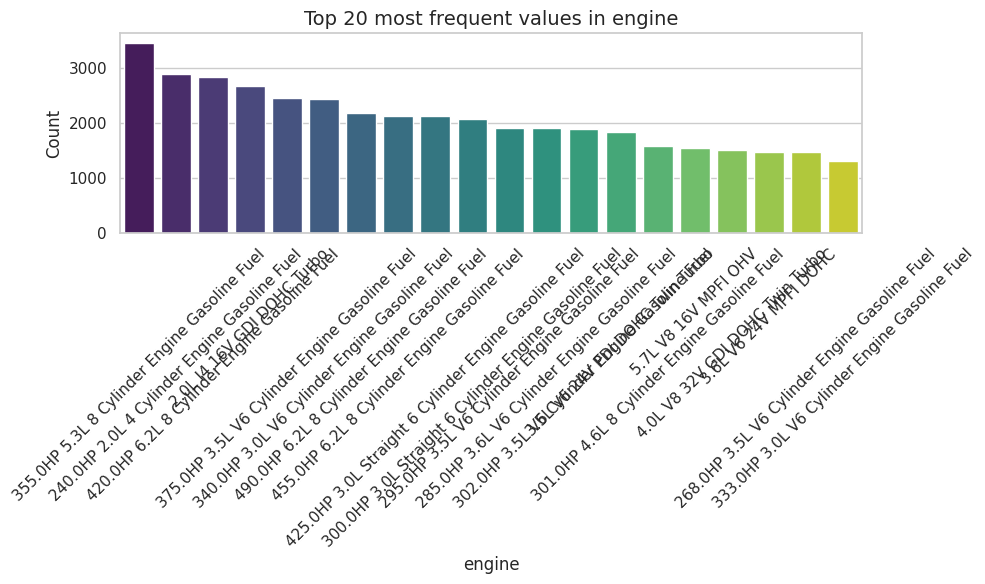

Column: engine
engine
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel             3462
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel             2902
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel             2841
2.0L I4 16V GDI DOHC Turbo                               2680
375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel            2451
340.0HP 3.0L V6 Cylinder Engine Gasoline Fuel            2436
490.0HP 6.2L 8 Cylinder Engine Gasoline Fuel             2187
455.0HP 6.2L 8 Cylinder Engine Gasoline Fuel             2138
425.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel    2134
300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel    2084
295.0HP 3.5L V6 Cylinder Engine Gasoline Fuel            1917
285.0HP 3.6L V6 Cylinder Engine Gasoline Fuel            1910
302.0HP 3.5L V6 Cylinder Engine Gasoline Fuel            1895
3.5L V6 24V PDI DOHC Twin Turbo                          1842
301.0HP 4.6L 8 Cylinder Engine Gasoline Fuel             1578
5.7L V8 16V MPFI OHV                            

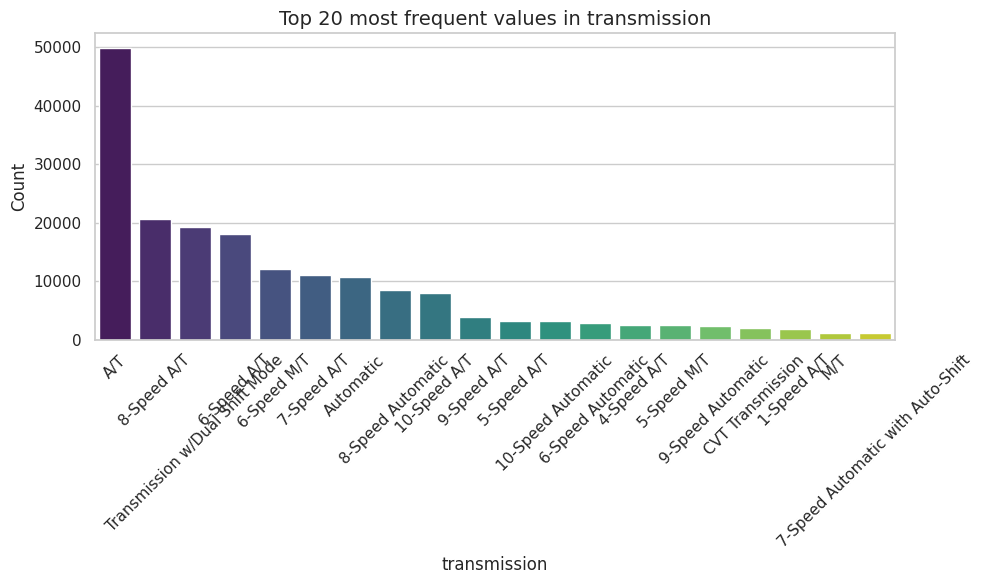

Column: transmission
transmission
A/T                                  49904
8-Speed A/T                          20645
Transmission w/Dual Shift Mode       19255
6-Speed A/T                          18044
6-Speed M/T                          11998
7-Speed A/T                          11124
Automatic                            10691
8-Speed Automatic                     8431
10-Speed A/T                          8044
9-Speed A/T                           3866
5-Speed A/T                           3217
10-Speed Automatic                    3164
6-Speed Automatic                     2799
4-Speed A/T                           2546
5-Speed M/T                           2409
9-Speed Automatic                     2325
CVT Transmission                      1990
1-Speed A/T                           1869
M/T                                   1179
7-Speed Automatic with Auto-Shift     1172
Name: count, dtype: int64

Missing values: 0 (0.00%)




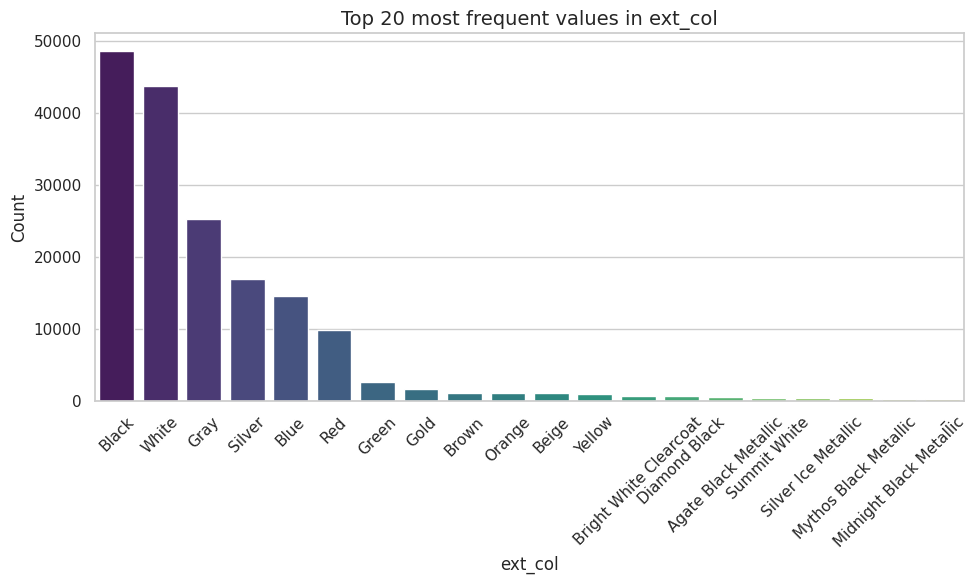

Column: ext_col
ext_col
Black                      48658
White                      43815
Gray                       25293
Silver                     16995
Blue                       14555
Red                         9901
Green                       2698
Gold                        1668
Brown                       1162
Orange                      1139
Beige                       1087
Yellow                       978
Bright White Clearcoat       755
Diamond Black                711
Agate Black Metallic         639
Summit White                 514
Silver Ice Metallic          456
Mythos Black Metallic        417
Midnight Black Metallic      379
–                            366
Name: count, dtype: int64

Missing values: 0 (0.00%)




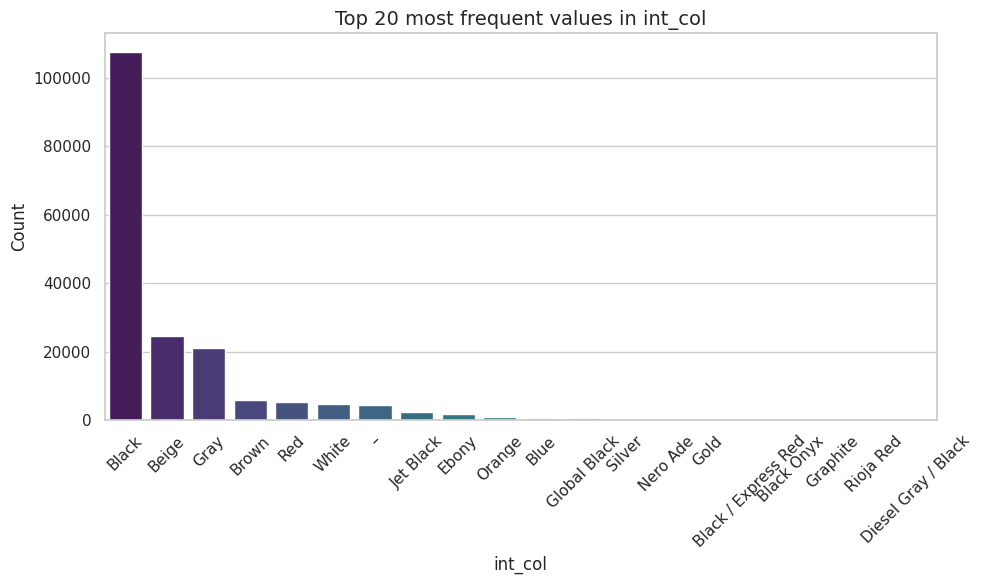

Column: int_col
int_col
Black                  107674
Beige                   24495
Gray                    21204
Brown                    5810
Red                      5145
White                    4743
–                        4527
Jet Black                2398
Ebony                    1833
Orange                    932
Blue                      743
Global Black              628
Silver                    429
Nero Ade                  389
Gold                      367
Black / Express Red       326
Black Onyx                256
Graphite                  254
Rioja Red                 244
Diesel Gray / Black       223
Name: count, dtype: int64

Missing values: 0 (0.00%)




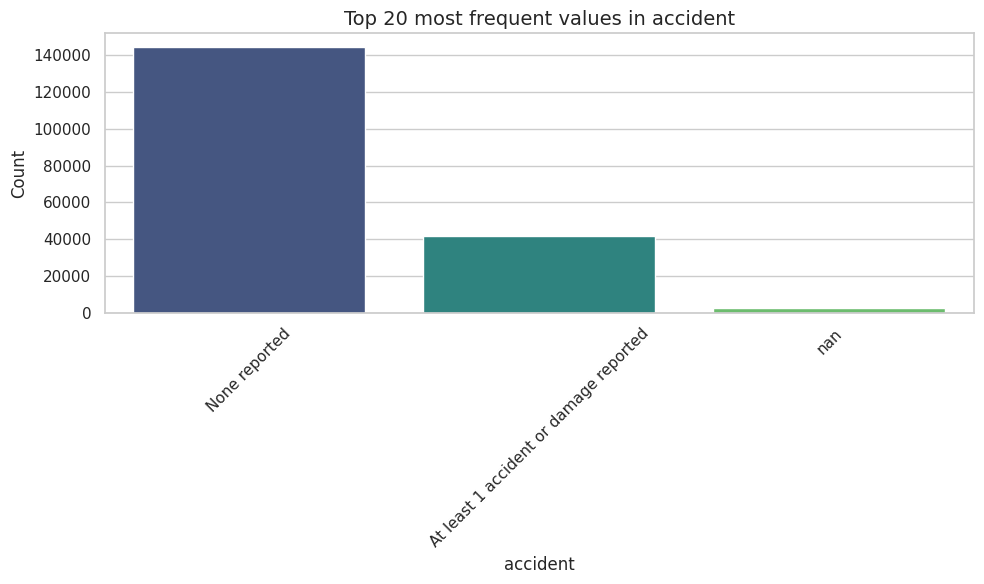

Column: accident
accident
None reported                             144514
At least 1 accident or damage reported     41567
NaN                                         2452
Name: count, dtype: int64

Missing values: 2452 (1.30%)




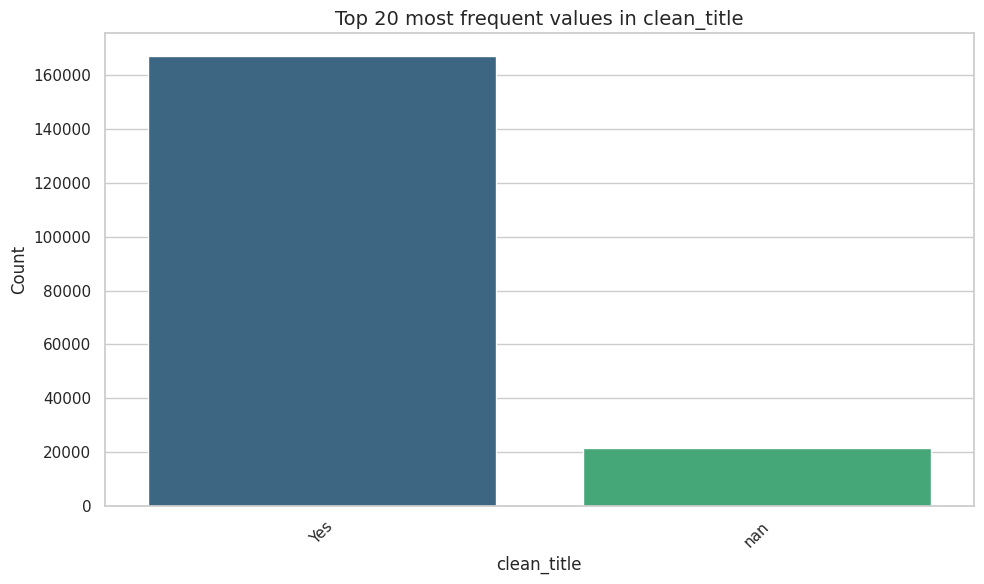

Column: clean_title
clean_title
Yes    167114
NaN     21419
Name: count, dtype: int64

Missing values: 21419 (11.36%)




In [12]:
def unique_values_visualize(df, num_cols=None, cat_cols=None, top_n=20, show_plots=True):
    """
    Analyzes and optionally visualizes the unique values of numerical and categorical columns in the DataFrame.
    Displays the count and percentage of missing values both in text and in the plot with the "Missing" label.
    
    Parameters:
    df (DataFrame): The dataset to be analyzed.
    num_cols (list): List of numerical columns. Default is None.
    cat_cols (list): List of categorical columns. Default is None.
    top_n (int): Shows the top n most frequent values for categorical columns. Default is 20.
    show_plots (bool): Controls whether the plots will be displayed. Default is True.
    """

    sns.set_theme(style="whitegrid")
    plt.rcParams.update({'figure.figsize': (10, 6), 'axes.titlesize': 14, 'axes.labelsize': 12})

    if num_cols:
        for col in num_cols:
            if show_plots:
                plt.figure()
                data = df[col].copy()
                data = data.fillna("Missing")
                sns.histplot(data, kde=False, bins=50, color="dodgerblue")
                
                plt.title(f"Distribution of {col}")
                plt.xlabel(col)
                plt.ylabel("Frequency")
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
            print(f"Column: {col}")
            print(f"Number of unique values: {df[col].nunique()}")
            print(f"Missing values: {df[col].isnull().sum()} ({df[col].isnull().mean() * 100:.2f}%)\n\n")

    if cat_cols:
        for col in cat_cols:
            value_counts = df[col].value_counts(dropna=False).head(top_n)
            if show_plots:
                plt.figure()
                categories = value_counts.index.astype(str)
                sns.barplot(x=categories, y=value_counts.values, palette="viridis")
                
                plt.title(f"Top {top_n} most frequent values in {col}")
                plt.xlabel(col)
                plt.ylabel("Count")
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
            print(f"Column: {col}")
            print(f"{value_counts}\n")
            print(f"Missing values: {df[col].isnull().sum()} ({df[col].isnull().mean() * 100:.2f}%)\n\n")

unique_values_visualize(df_train, num_cols, cat_cols, 20, show_plots=True)


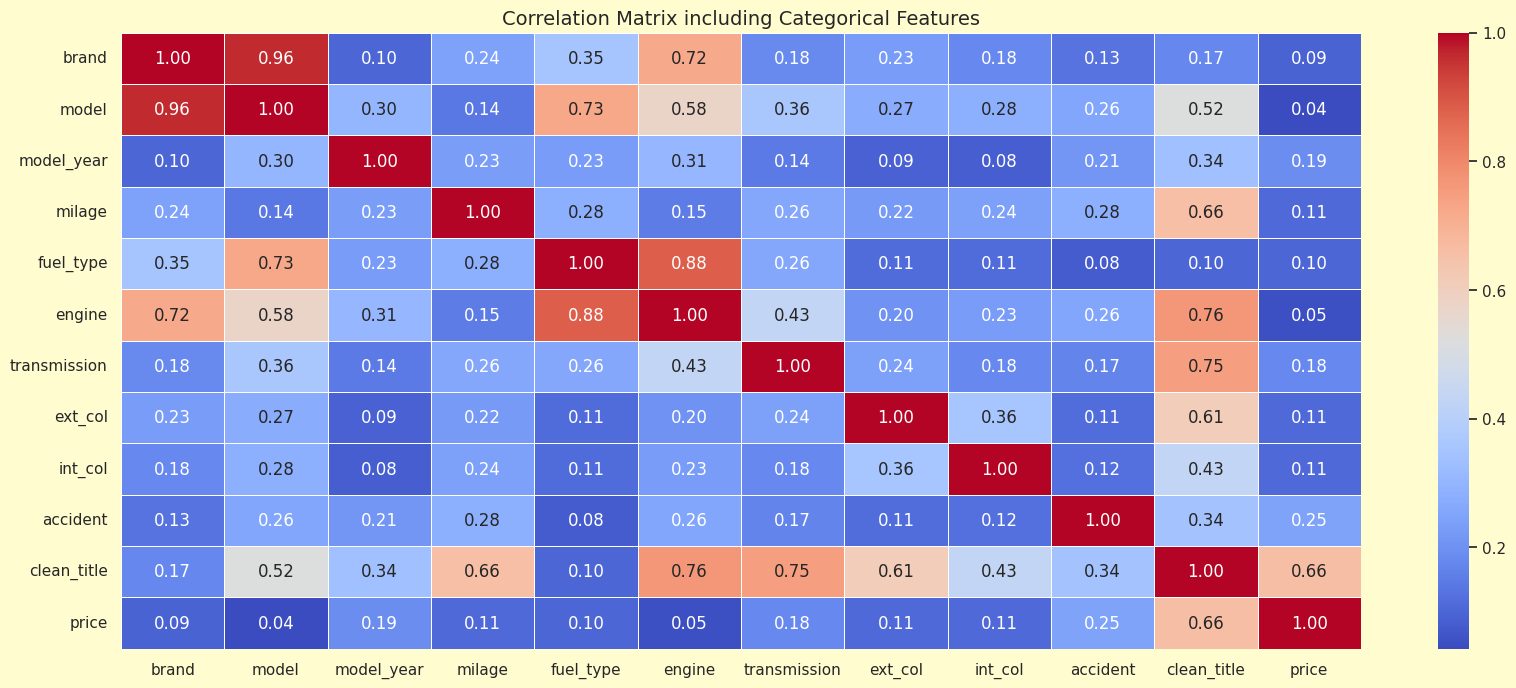

In [13]:
associations_df = associations(df_train, nominal_columns='all', plot=False)
corr_matrix = associations_df['corr']
plt.figure(figsize=(20, 8))
plt.gcf().set_facecolor('#FFFDD0') 
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix including Categorical Features')
plt.show()

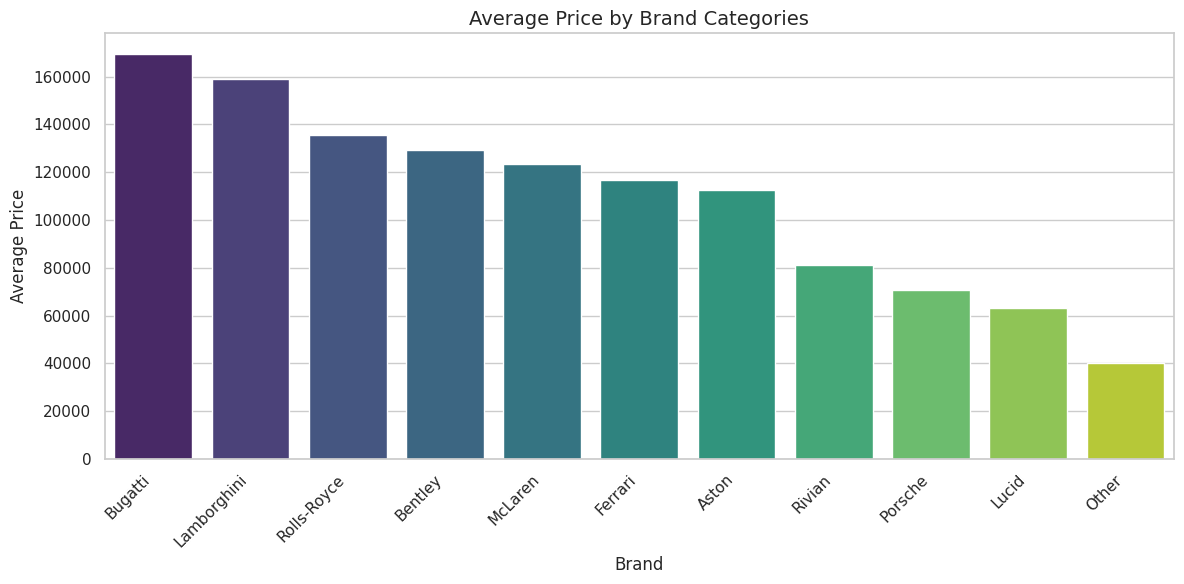


brand Column Target Summary:


,TARGET_MEAN,TARGET_MEDIAN,COUNT,TARGET_STD
brand,,,,
Bugatti,169600.000000,220000.0,7,82980.479632
Lamborghini,159176.012361,102000.0,809,179716.856915
Rolls-Royce,135488.650624,77500.0,561,178508.968481
Bentley,129272.933333,73600.0,1155,221562.656897
McLaren,123261.238683,87500.0,243,98033.990626
Ferrari,116751.005571,75500.0,359,134929.620477
Aston,112364.588235,67650.0,238,213527.990537
Rivian,81089.154237,78000.0,590,57988.867542
Porsche,70899.947795,45900.0,10612,112993.037388


----------------------------------------------------------------------------------------------------



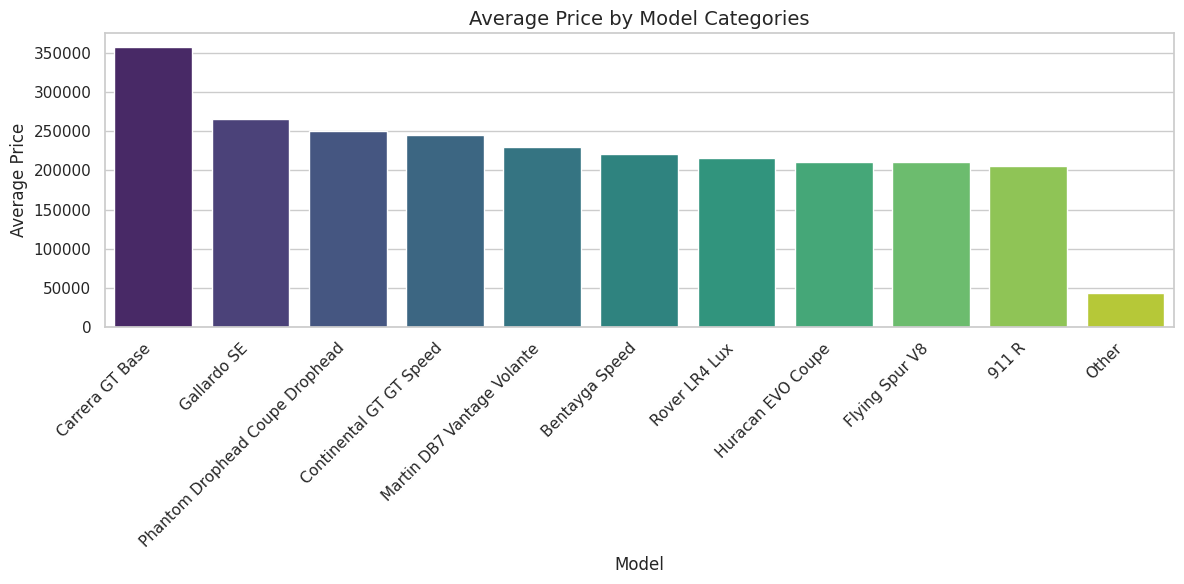


model Column Target Summary:


,TARGET_MEAN,TARGET_MEDIAN,COUNT,TARGET_STD
model,,,,
Carrera GT Base,356937.250000,141500.0,8,550957.554821
Gallardo SE,265551.272727,142249.5,22,351859.464692
Phantom Drophead Coupe Drophead,250358.269231,181237.5,26,205407.180338
Continental GT GT Speed,244661.833333,98500.0,18,440351.653919
Martin DB7 Vantage Volante,229714.312500,45750.0,16,727232.907878
Bentayga Speed,220777.552632,182253.0,76,216988.098259
Rover LR4 Lux,215266.133333,17816.0,15,757751.206341
Huracan EVO Coupe,211282.961538,243000.0,26,162250.797381
Flying Spur V8,211032.000000,192825.0,28,162184.034173


----------------------------------------------------------------------------------------------------



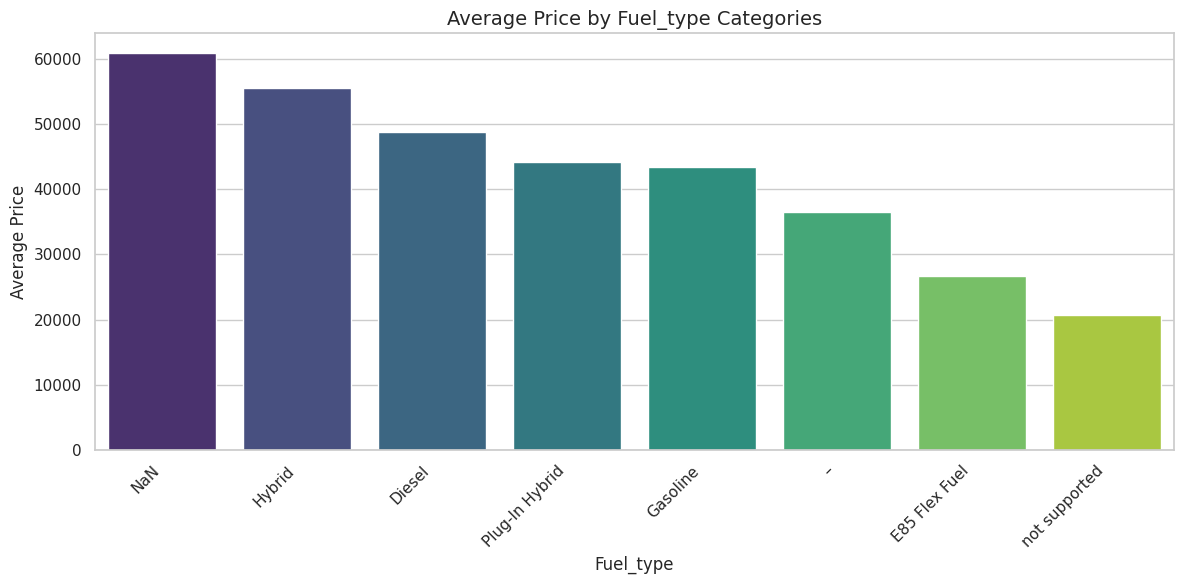


fuel_type Column Target Summary:


,TARGET_MEAN,TARGET_MEDIAN,COUNT,TARGET_STD
fuel_type,,,,
NaN,60822.612040,49999.0,5083,67237.070325
Hybrid,55473.451698,44900.0,6832,57999.203856
Diesel,48769.587358,38500.0,3955,93900.220809
Plug-In Hybrid,44150.967370,38880.0,521,29218.461832
Gasoline,43360.013782,29999.0,165940,79805.746347
–,36414.285531,16250.0,781,128210.312158
E85 Flex Fuel,26729.755457,19900.0,5406,54669.855994
not supported,20692.733333,14000.0,15,17726.392428


----------------------------------------------------------------------------------------------------



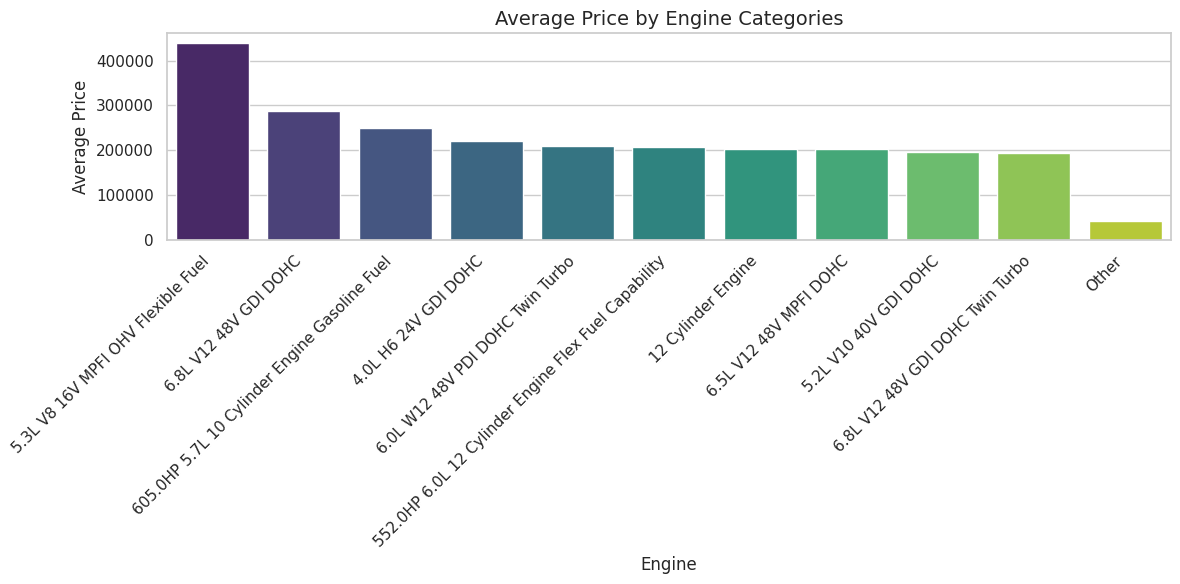


engine Column Target Summary:


,TARGET_MEAN,TARGET_MEDIAN,COUNT,TARGET_STD
engine,,,,
5.3L V8 16V MPFI OHV Flexible Fuel,438810.285714,18051.0,7,1.109167e+06
6.8L V12 48V GDI DOHC,288679.888889,279925.0,18,2.049261e+05
605.0HP 5.7L 10 Cylinder Engine Gasoline Fuel,250087.538462,52000.0,13,4.457565e+05
4.0L H6 24V GDI DOHC,221396.559567,154900.0,277,3.066543e+05
6.0L W12 48V PDI DOHC Twin Turbo,210264.102190,162950.0,137,2.826584e+05
552.0HP 6.0L 12 Cylinder Engine Flex Fuel Capability,207748.166667,47550.0,12,5.499932e+05
12 Cylinder Engine,204101.375000,213970.5,8,1.309796e+05
6.5L V12 48V MPFI DOHC,202073.898990,103900.0,99,2.524616e+05
5.2L V10 40V GDI DOHC,197061.905263,186925.0,190,2.084543e+05


----------------------------------------------------------------------------------------------------



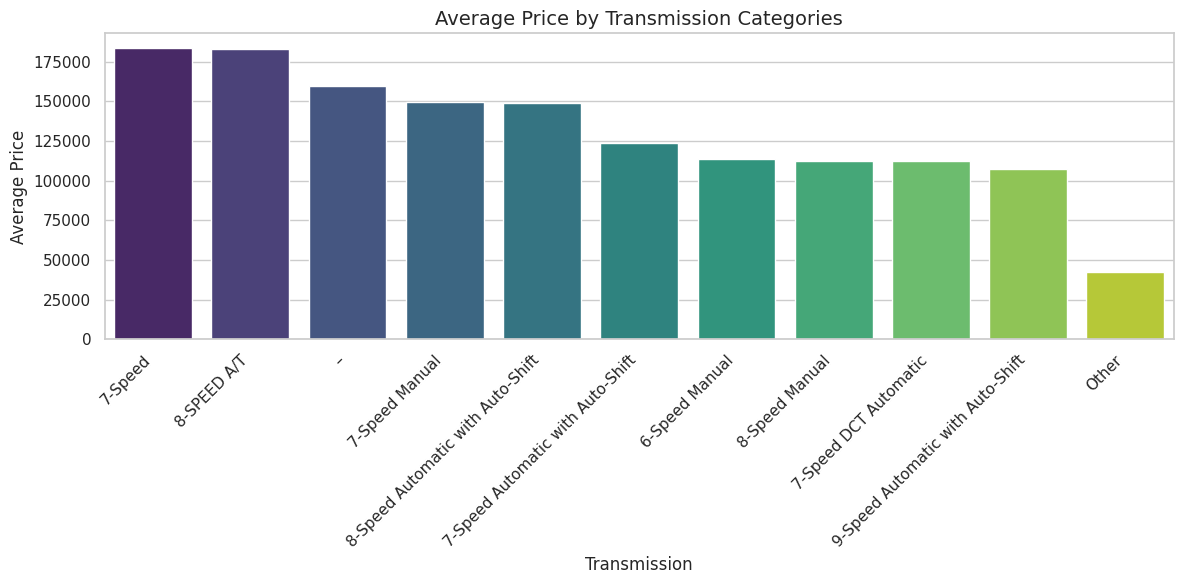


transmission Column Target Summary:


,TARGET_MEAN,TARGET_MEDIAN,COUNT,TARGET_STD
transmission,,,,
7-Speed,183672.586207,132900.0,29,155430.571609
8-SPEED A/T,182691.000000,162500.0,7,139339.512356
–,159504.091954,94500.0,87,210062.502709
7-Speed Manual,149622.668874,116911.0,151,123862.489200
8-Speed Automatic with Auto-Shift,148894.349727,99950.0,549,162231.178343
7-Speed Automatic with Auto-Shift,123758.630546,67979.0,1172,183560.346628
6-Speed Manual,113867.298578,52999.0,211,208612.872525
8-Speed Manual,112693.928571,85317.0,28,77130.074023
7-Speed DCT Automatic,112569.444444,61452.5,18,174408.560026


----------------------------------------------------------------------------------------------------



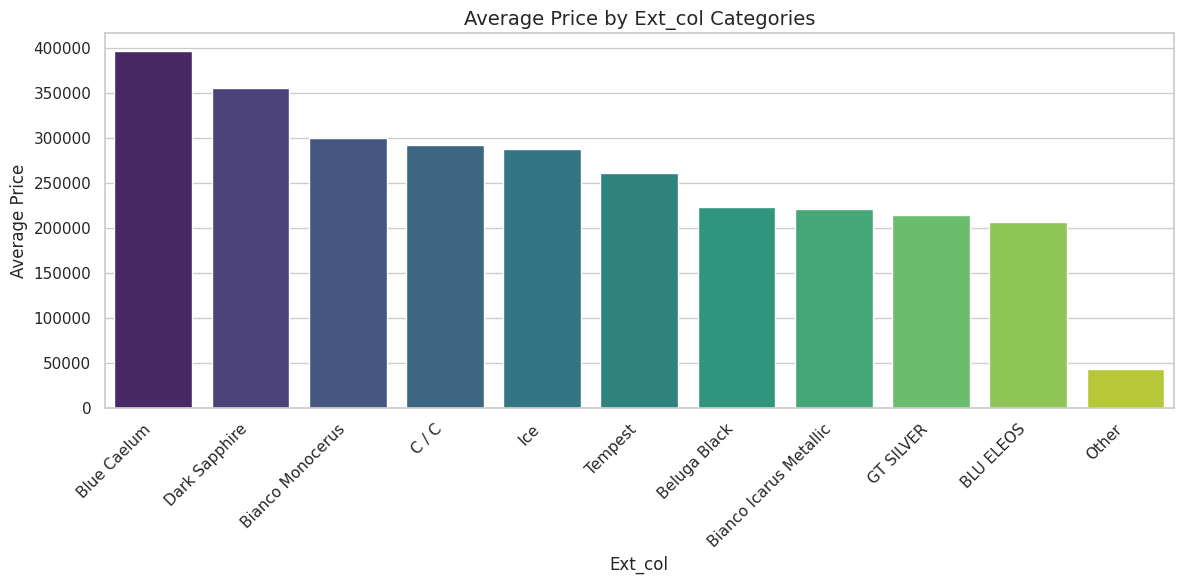


ext_col Column Target Summary:


,TARGET_MEAN,TARGET_MEDIAN,COUNT,TARGET_STD
ext_col,,,,
Blue Caelum,396263.600000,52645.0,5,679065.234472
Dark Sapphire,355541.454545,61599.0,11,865692.351449
Bianco Monocerus,300063.076923,179900.0,13,416357.867330
C / C,292528.088235,179900.0,34,440097.958464
Ice,288203.272727,217950.0,33,295000.224748
Tempest,261495.750000,163425.0,8,262724.839577
Beluga Black,222964.363636,122950.0,77,361174.415350
Bianco Icarus Metallic,221547.277778,229450.0,72,199969.997154
GT SILVER,214287.200000,135800.0,5,163946.096688


----------------------------------------------------------------------------------------------------



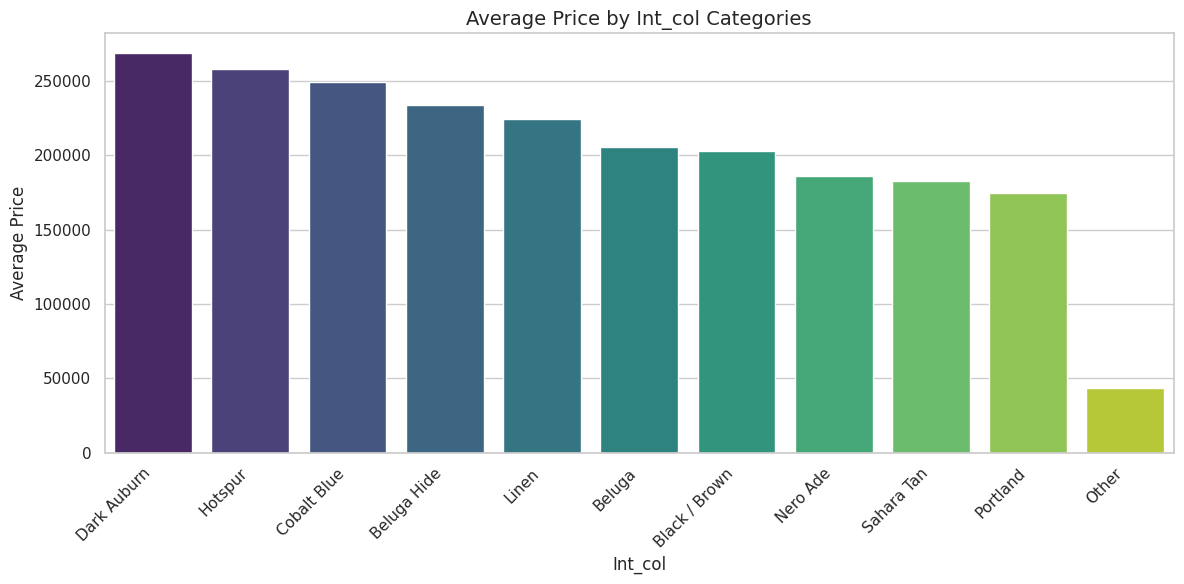


int_col Column Target Summary:


,TARGET_MEAN,TARGET_MEDIAN,COUNT,TARGET_STD
int_col,,,,
Dark Auburn,268591.333333,56900.0,15,746588.494796
Hotspur,257780.844444,117900.0,45,403182.168646
Cobalt Blue,249600.666667,164475.0,6,244347.387432
Beluga Hide,233563.625000,196357.5,48,269045.438781
Linen,224166.555556,77535.0,27,553573.535509
Beluga,205607.200000,201529.0,10,146883.652543
Black / Brown,203085.638889,128950.0,36,325861.413601
Nero Ade,186171.642674,159998.0,389,188300.133598
Sahara Tan,182831.516129,162950.0,31,130798.771844


----------------------------------------------------------------------------------------------------



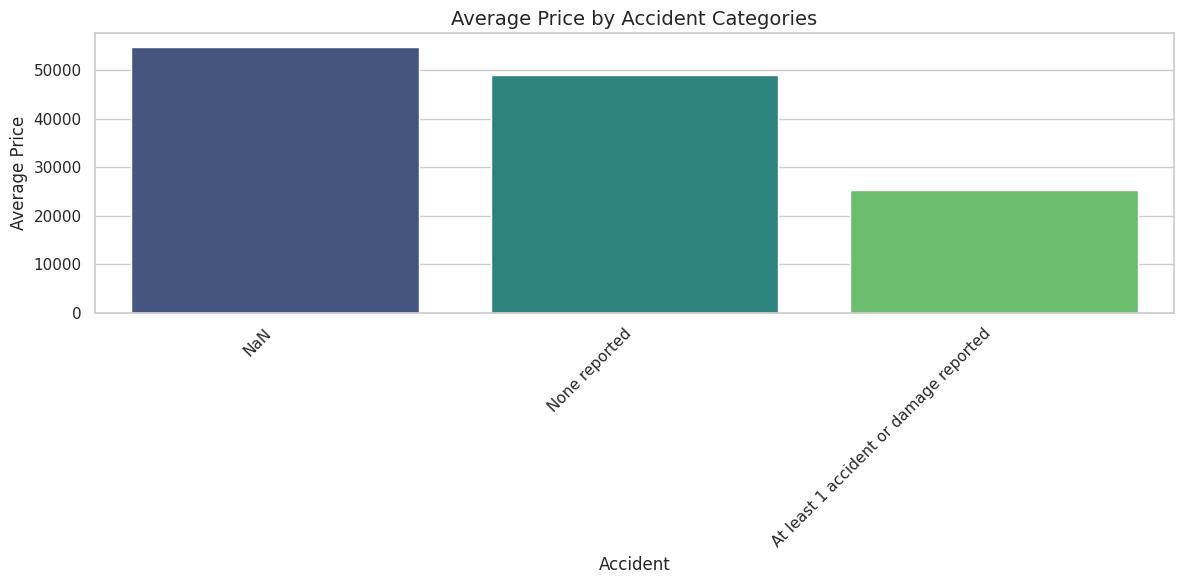


accident Column Target Summary:


,TARGET_MEAN,TARGET_MEDIAN,COUNT,TARGET_STD
accident,,,,
NaN,54902.988989,38999.0,2452,101802.822367
None reported,49024.804144,35000.0,144514,84593.013790
At least 1 accident or damage reported,25334.071475,18000.0,41567,47378.623057


----------------------------------------------------------------------------------------------------



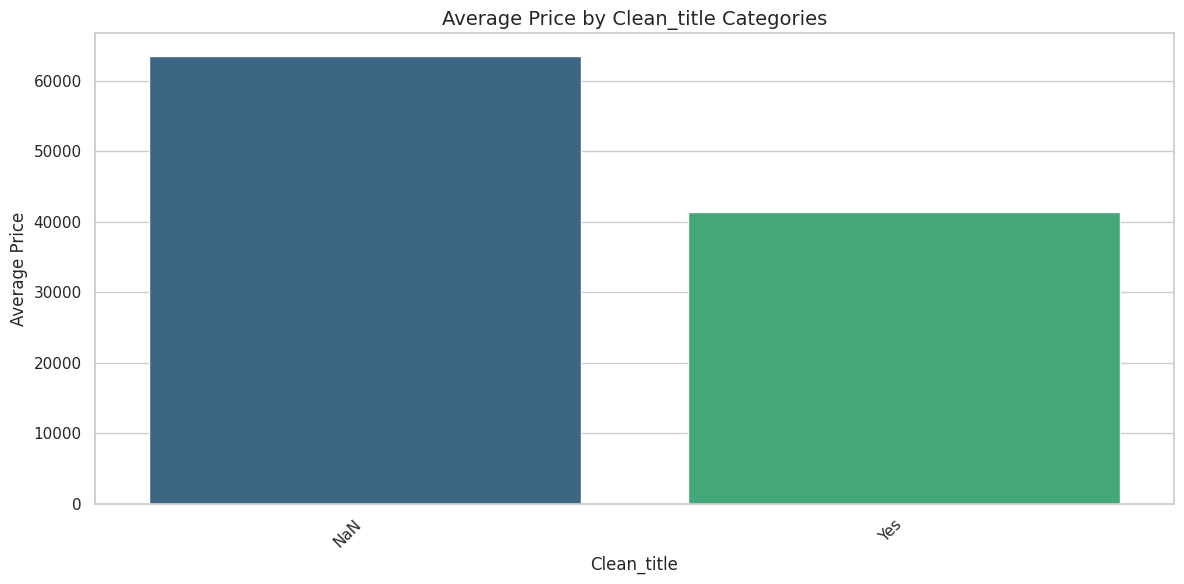


clean_title Column Target Summary:


,TARGET_MEAN,TARGET_MEDIAN,COUNT,TARGET_STD
clean_title,,,,
NaN,63567.566273,43666.0,21419,93164.463662
Yes,41354.406704,29000.0,167114,76421.863672


----------------------------------------------------------------------------------------------------



In [14]:
def target_summary_with_cat(dataframe, target, categorical_col, top_n=10, plot=True):
    """
    Calculates and visualizes summary statistics of the target variable for a categorical column.
    
    Parameters:
    - dataframe (pd.DataFrame): The data frame containing the data.
    - target (str): The name of the target variable.
    - categorical_col (str): The name of the categorical column to analyze.
    - top_n (int): The number of top categories to consider based on the mean of the target variable. Default is 10.
    - plot (bool): Whether to generate a bar plot of the summary statistics. Default is True.
    
    Returns:
    - pd.DataFrame: A data frame containing the summary statistics.
    """
    df_plot = dataframe.copy()

    df_plot[categorical_col] = df_plot[categorical_col].fillna('NaN')

    category_means = df_plot.groupby(categorical_col)[target].mean()

    top_categories = category_means.nlargest(top_n).index

    df_plot[categorical_col] = df_plot[categorical_col].apply(
        lambda x: x if x in top_categories else ('Other' if x != 'NaN' else 'NaN')
    )

    summary = (df_plot.groupby(categorical_col)[target]
               .agg(['mean', 'median', 'count', 'std'])
               .rename(columns={'mean': 'TARGET_MEAN', 'median': 'TARGET_MEDIAN', 'count': 'COUNT', 'std': 'TARGET_STD'})
               .sort_values('TARGET_MEAN', ascending=False)
               .reset_index())

    summary.set_index(categorical_col, inplace=True)

    # Visualization
    if plot:
        plt.figure(figsize=(12, 6))
        sns.barplot(x=summary.index, y='TARGET_MEAN', data=summary, palette='viridis')
        plt.title(f'Average {target.capitalize()} by {categorical_col.capitalize()} Categories')
        plt.xlabel(categorical_col.capitalize())
        plt.ylabel(f'Average {target.capitalize()}')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    print(f"\n{categorical_col} Column Target Summary:")
    display(summary)
    print(f"{'-'*100}\n")
    
    return summary

for col in cat_cols:
    target_summary_with_cat(df_train, target, col, top_n=10, plot=True)

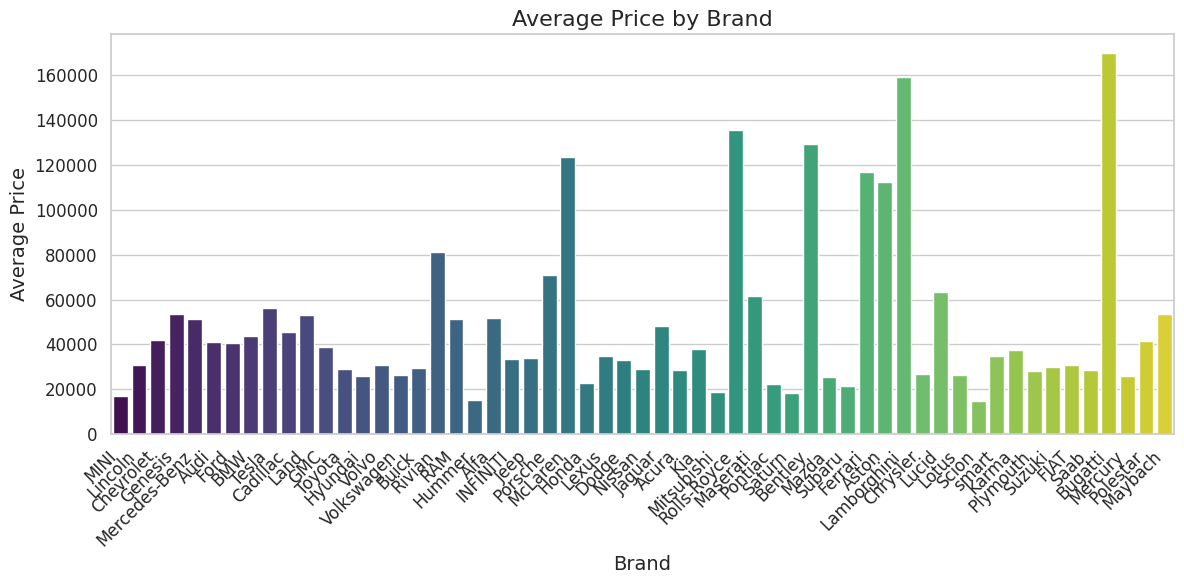

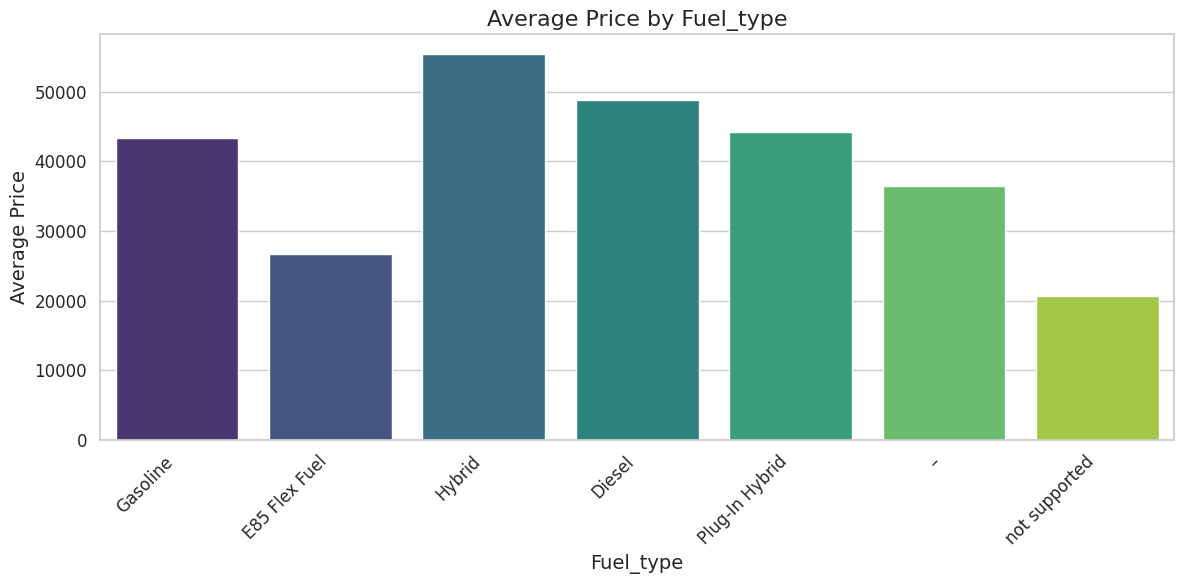

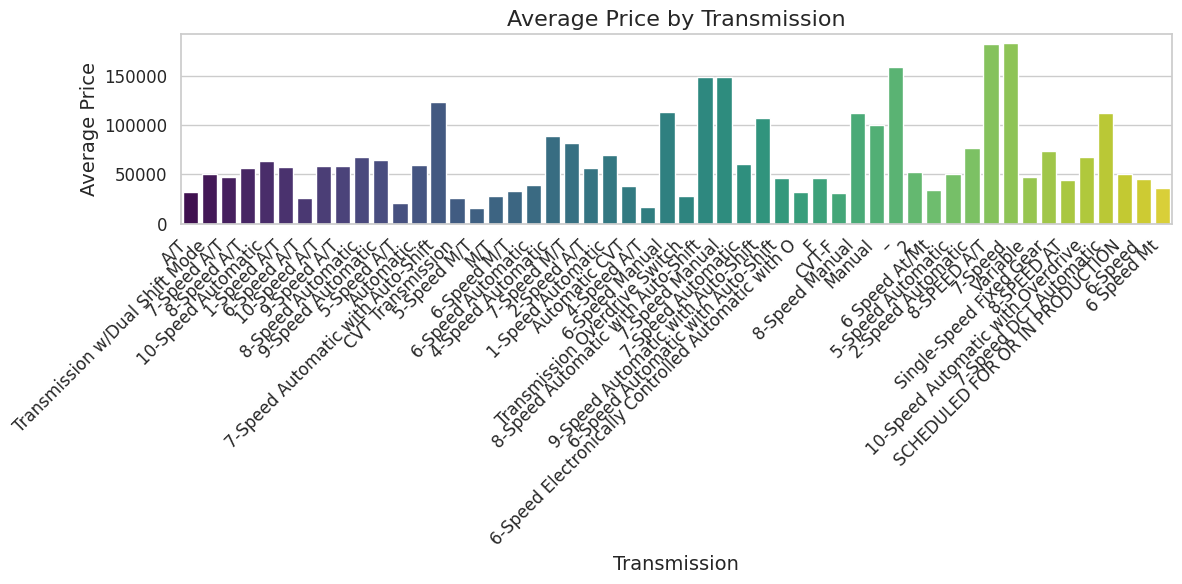

In [15]:
sns.set_theme(style="whitegrid")

for col in ['brand', 'fuel_type', 'transmission']:
    plt.figure(figsize=(12, 6))
    sns.barplot(x=col, y=target, data=df_train, estimator=np.mean, ci=None, palette="viridis")
    plt.title(f"Average {target.capitalize()} by {col.capitalize()}", fontsize=16)
    plt.xlabel(col.capitalize(), fontsize=14)
    plt.ylabel(f"Average {target.capitalize()}", fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

In [16]:
analyse_data(df_train,df_train.columns)

,Column,Uniques,frequency,Nans,ShareOfNans
0,brand,"[MINI, Lincoln, Chevrolet, Genesis, Mercedes-B...",57,0,0.00
1,model,"[Cooper S Base, LS V8, Silverado 2500 LT, G90 ...",1897,0,0.00
2,model_year,"[2007, 2002, 2017, 2021, 2018, 2016, 2020, 201...",34,0,0.00
3,milage,"[213000, 143250, 136731, 19500, 7388, 40950, 6...",6651,0,0.00
4,fuel_type,"[Gasoline, E85 Flex Fuel, nan, Hybrid, Diesel,...",8,5083,2.70
5,engine,"[172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,...",1117,0,0.00
6,transmission,"[A/T, Transmission w/Dual Shift Mode, 7-Speed ...",52,0,0.00
7,ext_col,"[Yellow, Silver, Blue, Black, White, Snowflake...",319,0,0.00
8,int_col,"[Gray, Beige, Black, –, Blue, White, Red, Brow...",156,0,0.00
9,accident,"[None reported, At least 1 accident or damage ...",3,2452,1.30


In [17]:
analyse_data(df_test,df_test.columns)

,Column,Uniques,frequency,Nans,ShareOfNans
0,brand,"[Land, Ford, Audi, Chevrolet, Lexus, Mercedes-...",55,0,0.00
1,model,"[Rover LR2 Base, Rover Defender SE, Expedition...",1891,0,0.00
2,model_year,"[2015, 2020, 2022, 2016, 2018, 2013, 2008, 201...",36,0,0.00
3,milage,"[98000, 9142, 28121, 61258, 59000, 99524, 1940...",5700,0,0.00
4,fuel_type,"[Gasoline, Hybrid, Diesel, E85 Flex Fuel, nan,...",8,3383,2.69
5,engine,"[240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,...",1117,0,0.00
6,transmission,"[6-Speed A/T, 8-Speed A/T, 10-Speed Automatic,...",52,0,0.00
7,ext_col,"[White, Silver, Silician Yellow, Gray, Black, ...",317,0,0.00
8,int_col,"[Beige, Black, Ebony, Gray, Jet Black, –, Red,...",156,0,0.00
9,accident,"[None reported, At least 1 accident or damage ...",3,1632,1.30


In [18]:
from sklearn.impute import SimpleImputer
def impute_mode(df, columns):
    mode_imputer = SimpleImputer(strategy='most_frequent')
    for col in columns:
        df[col] = mode_imputer.fit_transform(df[[col]]).ravel()
    return df

columns_to_impute = ['fuel_type', 'accident', 'clean_title']

df_train = impute_mode(df_train, columns_to_impute)
df_test = impute_mode(df_test, columns_to_impute)

In [19]:
analyse_data(df_train,df_train.columns)

,Column,Uniques,frequency,Nans,ShareOfNans
0,brand,"[MINI, Lincoln, Chevrolet, Genesis, Mercedes-B...",57,0,0.0
1,model,"[Cooper S Base, LS V8, Silverado 2500 LT, G90 ...",1897,0,0.0
2,model_year,"[2007, 2002, 2017, 2021, 2018, 2016, 2020, 201...",34,0,0.0
3,milage,"[213000, 143250, 136731, 19500, 7388, 40950, 6...",6651,0,0.0
4,fuel_type,"[Gasoline, E85 Flex Fuel, Hybrid, Diesel, Plug...",7,0,0.0
5,engine,"[172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,...",1117,0,0.0
6,transmission,"[A/T, Transmission w/Dual Shift Mode, 7-Speed ...",52,0,0.0
7,ext_col,"[Yellow, Silver, Blue, Black, White, Snowflake...",319,0,0.0
8,int_col,"[Gray, Beige, Black, –, Blue, White, Red, Brow...",156,0,0.0
9,accident,"[None reported, At least 1 accident or damage ...",2,0,0.0


In [20]:
df_train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [21]:
analyse_data(df_test,df_test.columns)

,Column,Uniques,frequency,Nans,ShareOfNans
0,brand,"[Land, Ford, Audi, Chevrolet, Lexus, Mercedes-...",55,0,0.0
1,model,"[Rover LR2 Base, Rover Defender SE, Expedition...",1891,0,0.0
2,model_year,"[2015, 2020, 2022, 2016, 2018, 2013, 2008, 201...",36,0,0.0
3,milage,"[98000, 9142, 28121, 61258, 59000, 99524, 1940...",5700,0,0.0
4,fuel_type,"[Gasoline, Hybrid, Diesel, E85 Flex Fuel, Plug...",7,0,0.0
5,engine,"[240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,...",1117,0,0.0
6,transmission,"[6-Speed A/T, 8-Speed A/T, 10-Speed Automatic,...",52,0,0.0
7,ext_col,"[White, Silver, Silician Yellow, Gray, Black, ...",317,0,0.0
8,int_col,"[Beige, Black, Ebony, Gray, Jet Black, –, Red,...",156,0,0.0
9,accident,"[None reported, At least 1 accident or damage ...",2,0,0.0


In [22]:
df_test.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
id,,,,,,,,,,,
188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,Yes
188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,Yes
188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [23]:
def categorize_age(age):
    if age <= 5:
        return 'Recent'
    elif 6 <= age <= 10:
        return 'Moderate'
    elif 11 <= age <= 20:
        return 'Old'
    else:
        return 'Vintage'

def preprocess_dataframe(df_train, df_test):
    dfs = [df_train, df_test]
    
    for df in dfs:
        df['Age'] = 2024 - df['model_year']
        df['NEW_age_category'] = df['Age'].apply(categorize_age)
        
        df['NEW_mileage_category'] = pd.cut(
            df['milage'], 
            bins=[-float('inf'), 10000, 50000, 100000, 150000, float('inf')],
            labels=['Low Mileage', 'Moderate Mileage', 'High Mileage', 
                    'Very High Mileage', 'Extremely High Mileage']
        )
        
        df['NEW_color_match'] = (df['ext_col'] == df['int_col']).astype(int)
        df['accident']=df['accident'].map({'None reported': 0,'At least 1 accident or damage reported': 1})
    
    return dfs[0], dfs[1]

df_train, df_test = preprocess_dataframe(df_train, df_test)

In [24]:
df_train.head(3)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,Age,NEW_age_category,NEW_mileage_category,NEW_color_match
id,,,,,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,0,Yes,4200,17,Old,Extremely High Mileage,0
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,1,Yes,4999,22,Vintage,Very High Mileage,0
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,0,Yes,13900,22,Vintage,Very High Mileage,0


In [25]:
df_test.head(3)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,Age,NEW_age_category,NEW_mileage_category,NEW_color_match
id,,,,,,,,,,,,,,,
188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,0,Yes,9,Moderate,High Mileage,0
188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,0,Yes,4,Recent,Low Mileage,0
188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,0,Yes,2,Recent,Moderate Mileage,0


In [26]:
missing_values_train = df_train.isna().sum().sum()
missing_values_test = df_test.isna().sum().sum()

print(missing_values_train,missing_values_test)

0 0


In [27]:
def change_df(df):
    df['accident'] = df['accident'].astype('object')
    df['NEW_mileage_category'] = df['NEW_mileage_category'].astype('object')
    df['NEW_color_match'] = df['NEW_color_match'].astype('object')
    return df

df_train = change_df(df_train)
df_test = change_df(df_test)

cat_cols = df_train.drop(target, axis=1).select_dtypes(include='object').columns.to_list()

num_cols = df_train.drop(target, axis=1).select_dtypes(exclude='object').columns.to_list()

for col in cat_cols:
    df_train[col] = df_train[col].astype('category')
    df_test[col] = df_test[col].astype('category')

print("Categorical Columns:", cat_cols, "\n\nNumerical Columns:", num_cols)

Categorical Columns: ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'NEW_age_category', 'NEW_mileage_category', 'NEW_color_match'] 

Numerical Columns: ['model_year', 'milage', 'Age']


In [28]:
label_encoder = LabelEncoder()

for col in cat_cols:
    combined_data = pd.concat([df_train[col].astype(str), df_test[col].astype(str)], axis=0)
    label_encoder.fit(combined_data)
    df_train[col] = label_encoder.transform(df_train[col].astype(str))
    df_test[col] = label_encoder.transform(df_test[col].astype(str))

scaler = StandardScaler()

for col in num_cols:
    df_train[col] = scaler.fit_transform(df_train[[col]])
    df_test[col] = scaler.transform(df_test[[col]])

In [29]:
df_train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,Age,NEW_age_category,NEW_mileage_category,NEW_color_match
id,,,,,,,,,,,,,,,,
0,31,495,-1.559808,2.957842,2,116,38,312,71,0,0,4200,1.559808,1,0,0
1,28,930,-2.443052,1.557184,2,367,38,263,10,1,0,4999,2.443052,3,4,0
2,9,1575,-2.443052,1.426276,1,641,38,38,71,0,0,13900,2.443052,3,4,0
3,16,758,0.206679,-0.927854,2,864,49,29,14,0,0,45000,-0.206679,0,3,1
4,36,1077,0.913274,-1.171076,2,260,23,29,10,0,0,97500,-0.913274,2,2,0


In [30]:
X_train  = df_train.drop(['price'], axis=1)
y_train  = df_train['price']
X_test = df_test.copy()

In [36]:
lgbm_params = {'n_estimators': 1110, 'num_leaves': 30, 'max_depth': 5, 'cat_smooth': 228, 'learning_rate': 0.02336206104083507, 'subsample': 0.9390488327529609, 'colsample_bytree': 0.6538883599346436, 'min_split_gain': 0.00028075289278372385, 'min_child_weight': 94, 'lambda_l2': 1.899471287613687, 'lambda_l1': 0.1594479718818871, 'max_bin': 671}
xgb_params = {'n_estimators': 1764, 'eta': 0.0077301110161525485, 'max_depth': 6, 'min_child_weight': 0.44960577045905026, 'subsample': 0.8822497895565136, 'colsample_bytree': 0.2956959125022117, 'lambda': 6.783476910098479, 'alpha': 0.4231157578625333}

In [39]:
lgbm_final = lgb.LGBMRegressor(**lgbm_params, verbose=-1, importance_type="gain")

lgbm_final.fit(X_train, y_train)

y_train_pred_lgbm = lgbm_final.predict(X_train)


rmse_lgbm = mean_squared_error(y_train, y_train_pred_lgbm, squared=False)
print(f"RMSE on training data (LightGBM): {rmse_lgbm}")

######################

xgb_final = xgb.XGBRegressor(**xgb_params)

xgb_final.fit(X_train, y_train)

y_train_pred_xgb = xgb_final.predict(X_train)

rmse_xgb = mean_squared_error(y_train, y_train_pred_xgb, squared=False)
print(f"RMSE on training data (XGBoost): {rmse_xgb}")

RMSE on training data (LightGBM): 71136.37609104646
RMSE on training data (XGBoost): 70597.05858395256


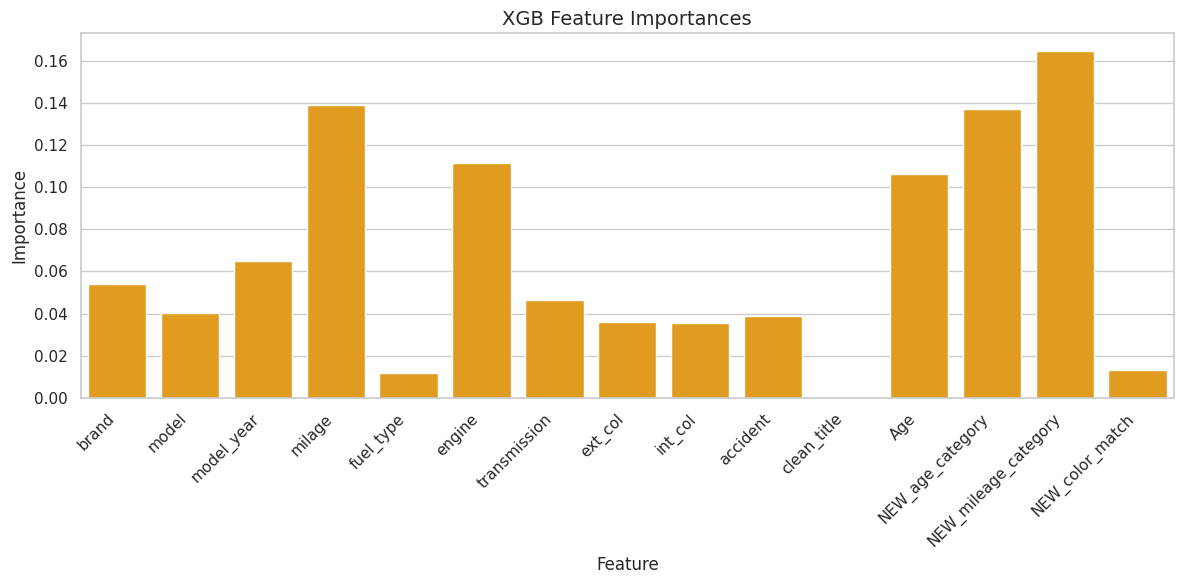

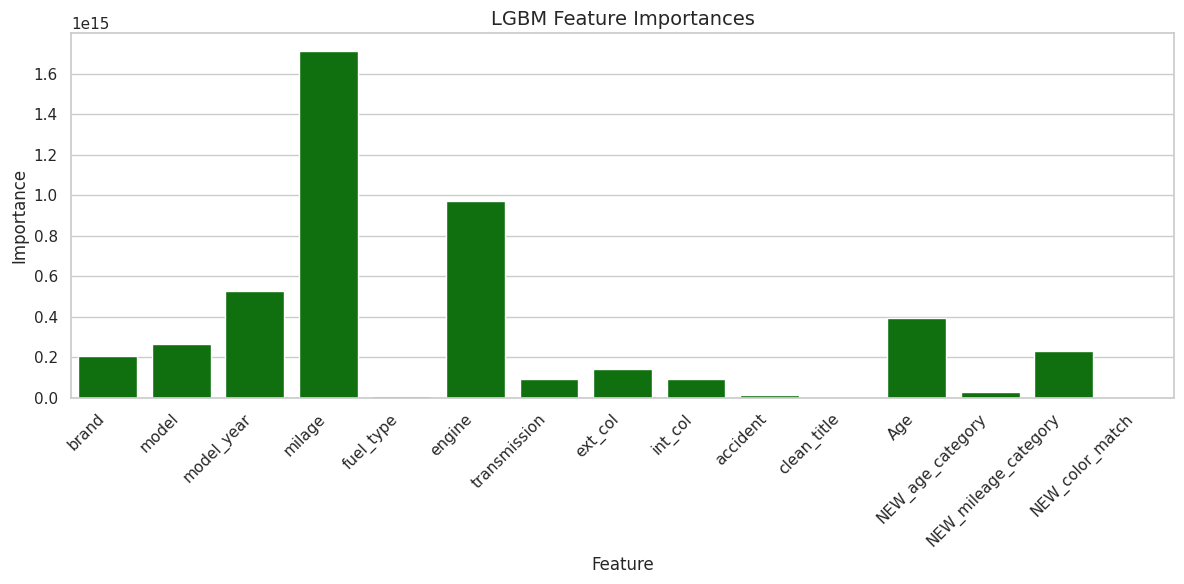

In [42]:
sns.set_theme(style="whitegrid")

importances_xgb = xgb_final.feature_importances_
plt.figure(figsize=(12, 6))
sns.barplot(x=X_train.columns, y=importances_xgb, color="orange") 
plt.xticks(rotation=45, ha="right")
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Importance", fontsize=12)
plt.title("XGB Feature Importances", fontsize=14)
plt.tight_layout()
plt.show()

importances_lgbm = lgbm_final.feature_importances_
plt.figure(figsize=(12, 6))
sns.barplot(x=X_train.columns, y=importances_lgbm, color="green") 
plt.xticks(rotation=45, ha="right")
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Importance", fontsize=12)
plt.title("LGBM Feature Importances", fontsize=14)
plt.tight_layout()
plt.show()

In [43]:
predict_lgbm = lgbm_final.predict(X_test)
submission_lgbm = pd.DataFrame({'id': df_test.index, 'price': predict_lgbm})
submission_lgbm.to_csv('submission_lgbm.csv', index=False)

predict_xgb = xgb_final.predict(X_test)
submission_xgb = pd.DataFrame({'id': df_test.index, 'price': predict_xgb})
submission_xgb.to_csv('submission_xgb.csv', index=False)

In [ ]:
submission_lgbm = pd.read_csv('submission_lgbm.csv')
submission_xgb = pd.read_csv('submission_xgb.csv')

predict_lgbm = submission_lgbm['price']
predict_xgb = submission_xgb['price']

weights = {
    'lgbm': 0.60,
    'xgb': 0.40,
}

blended_predictions = (
    weights['lgbm'] * predict_lgbm +
    weights['xgb'] * predict_xgb 
)

submission_blended = pd.DataFrame({
    'id': submission_lgbm['id'],
    'price': blended_predictions
})

submission_blended.to_csv('submission_blended.csv', index=False)

In [45]:
def xgb_objective(trial):
    xgb_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        'n_estimators': trial.suggest_int('n_estimators', 1000, 1900),
        'eta': trial.suggest_loguniform('eta', 0.0005, 0.3),  # learning rate
#         'max_depth':4,
        'max_depth': trial.suggest_int('max_depth', 3, 11),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-4, 10),
        'subsample': trial.suggest_uniform('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.09, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 3, 10),
        'alpha': trial.suggest_loguniform('alpha', 1e-4, 10),
        'tree_method': 'hist',  
        'device':'cuda',
        'n_jobs': -1,
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in kf.split(X_train):
        X_train_fold = X_train.iloc[train_idx]
        y_train_fold = y_train.iloc[train_idx]
        X_val_fold = X_train.iloc[val_idx]
        y_val_fold = y_train.iloc[val_idx]

        model = xgb.XGBRegressor(**xgb_params)

        model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            early_stopping_rounds=100,
            verbose=False
        )

        y_pred = model.predict(X_val_fold)
        score = np.sqrt(mean_squared_error(y_val_fold, y_pred))
        scores.append(score)

    return np.mean(scores)


def lgbm_objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'cat_smooth': trial.suggest_int('cat_smooth', 10, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
        'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-9, 10.0),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-9, 10.0),
        'max_bin': trial.suggest_int('max_bin', 100, 1000),
        'n_jobs': -1,
        'verbose': -1,
    }
    
    model = lgb.LGBMRegressor(**param)
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Early stopping
        early_stopping_callback = lgb.early_stopping(
            stopping_rounds=200, 
            verbose=False
        )
        
        model.fit(
            X_train_fold, 
            y_train_fold, 
            eval_set=[(X_val_fold, y_val_fold)],
            callbacks=[early_stopping_callback],
        )
        
        y_pred = model.predict(X_val_fold)
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

In [ ]:
print("Starting LightGBM Optimization...")
lgbm_study = optuna.create_study(direction='minimize', study_name='LightGBM Optimization')
lgbm_study.optimize(lgbm_objective, n_trials=40, show_progress_bar=True)
print(f"Best LightGBM Parameters: {lgbm_study.best_params}\n")

print("Starting XGBoost Optimization...")
xgb_study = optuna.create_study(direction='minimize', study_name='XGBoost Optimization')
xgb_study.optimize(xgb_objective, n_trials=50, show_progress_bar=True)
print(f"Best XGBoost Parameters: {xgb_study.best_params}\n")

[I 2024-12-06 19:50:21,844] A new study created in memory with name: LightGBM Optimization


Starting LightGBM Optimization...


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-12-06 19:50:49,557] Trial 0 finished with value: 72814.13291385815 and parameters: {'n_estimators': 401, 'num_leaves': 111, 'max_depth': 37, 'cat_smooth': 193, 'learning_rate': 0.007585538368361706, 'subsample': 0.9904831502577771, 'colsample_bytree': 0.9332877627896459, 'min_split_gain': 0.010483247796111778, 'min_child_weight': 60, 'lambda_l2': 0.0005312255986177864, 'lambda_l1': 2.452224556062665e-06, 'max_bin': 271}. Best is trial 0 with value: 72814.13291385815.
[I 2024-12-06 19:51:18,905] Trial 1 finished with value: 72862.08512317538 and parameters: {'n_estimators': 596, 'num_leaves': 287, 'max_depth': 23, 'cat_smooth': 250, 'learning_rate': 0.02627114412164993, 'subsample': 0.6523281312290587, 'colsample_bytree': 0.8793911419855736, 'min_split_gain': 0.017468278084322254, 'min_child_weight': 51, 'lambda_l2': 1.924168917083409e-05, 'lambda_l1': 5.284392090634351e-07, 'max_bin': 440}. Best is trial 0 with value: 72814.13291385815.
[I 2024-12-06 19:52:23,275] Trial 2 finis

[I 2024-12-06 19:53:57,323] A new study created in memory with name: XGBoost Optimization


[I 2024-12-06 19:53:57,318] Trial 4 finished with value: 72847.00829469346 and parameters: {'n_estimators': 595, 'num_leaves': 300, 'max_depth': 27, 'cat_smooth': 267, 'learning_rate': 0.007737791567471244, 'subsample': 0.7880927499584652, 'colsample_bytree': 0.7584564798197823, 'min_split_gain': 0.7320035295726708, 'min_child_weight': 40, 'lambda_l2': 9.811804347865644e-08, 'lambda_l1': 0.41245699960085513, 'max_bin': 721}. Best is trial 0 with value: 72814.13291385815.
Best LightGBM Parameters: {'n_estimators': 401, 'num_leaves': 111, 'max_depth': 37, 'cat_smooth': 193, 'learning_rate': 0.007585538368361706, 'subsample': 0.9904831502577771, 'colsample_bytree': 0.9332877627896459, 'min_split_gain': 0.010483247796111778, 'min_child_weight': 60, 'lambda_l2': 0.0005312255986177864, 'lambda_l1': 2.452224556062665e-06, 'max_bin': 271}

Starting XGBoost Optimization...


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-12-06 19:54:19,232] Trial 0 finished with value: 74081.15753949045 and parameters: {'n_estimators': 1504, 'eta': 0.0008606233090089827, 'max_depth': 4, 'min_child_weight': 0.000976247230564121, 'subsample': 0.9921325225641093, 'colsample_bytree': 0.5359857479473319, 'lambda': 7.656251039261296, 'alpha': 0.00024422663036099534}. Best is trial 0 with value: 74081.15753949045.
[I 2024-12-06 19:54:45,210] Trial 1 finished with value: 72758.54446732737 and parameters: {'n_estimators': 1052, 'eta': 0.007179973756506685, 'max_depth': 9, 'min_child_weight': 0.01924636624695149, 'subsample': 0.9001200909541927, 'colsample_bytree': 0.6830475894544844, 'lambda': 7.653548555084516, 'alpha': 0.03156089314043456}. Best is trial 1 with value: 72758.54446732737.
[I 2024-12-06 19:54:57,911] Trial 2 finished with value: 72635.8265430593 and parameters: {'n_estimators': 1580, 'eta': 0.02645792140372007, 'max_depth': 4, 'min_child_weight': 0.0029521102848595227, 'subsample': 0.614483378857634, 'co

In [47]:
lgbm_final = lgb.LGBMRegressor(**lgbm_study.best_params, verbose=-1, importance_type="gain")

lgbm_final.fit(X_train, y_train)

y_train_pred_lgbm = lgbm_final.predict(X_train)

rmse_lgbm = mean_squared_error(y_train, y_train_pred_lgbm, squared=False)
print(f"RMSE on training data (LightGBM): {rmse_lgbm}")

################

xgb_final = xgb.XGBRegressor(**xgb_study.best_params)

xgb_final.fit(X_train, y_train)

y_train_pred_xgb = xgb_final.predict(X_train)

rmse_xgb = mean_squared_error(y_train, y_train_pred_xgb, squared=False)
print(f"RMSE on training data (XGBoost): {rmse_xgb}")

RMSE on training data (LightGBM): 70489.18548620357
RMSE on training data (XGBoost): 70899.48126454449


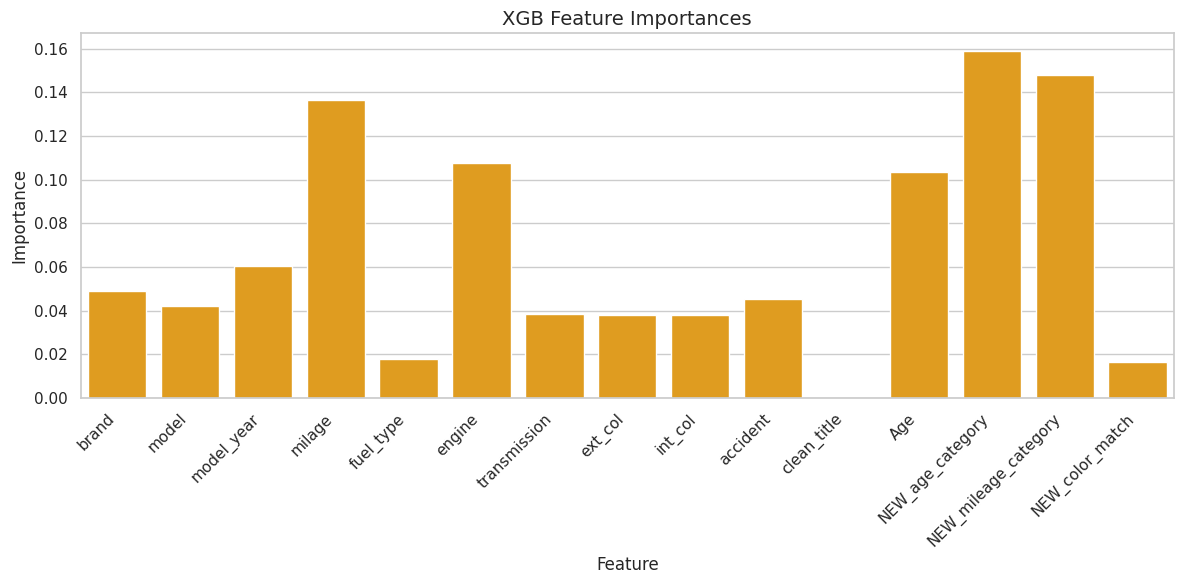

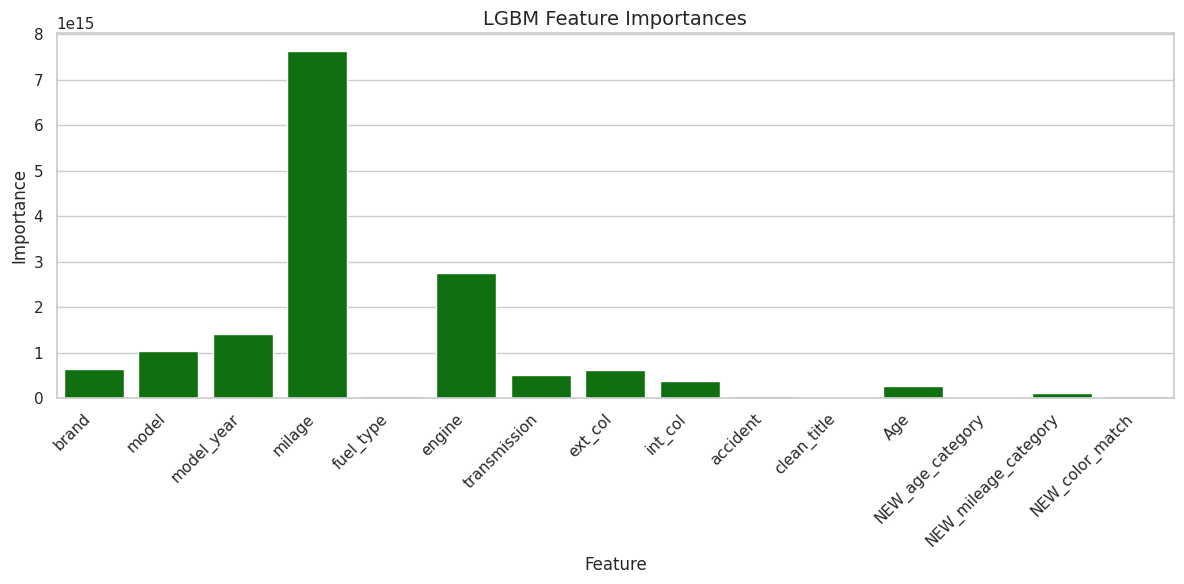

In [48]:
sns.set_theme(style="whitegrid")

importances_xgb = xgb_final.feature_importances_
plt.figure(figsize=(12, 6))
sns.barplot(x=X_train.columns, y=importances_xgb, color="orange") 
plt.xticks(rotation=45, ha="right")
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Importance", fontsize=12)
plt.title("XGB Feature Importances", fontsize=14)
plt.tight_layout()
plt.show()

importances_lgbm = lgbm_final.feature_importances_
plt.figure(figsize=(12, 6))
sns.barplot(x=X_train.columns, y=importances_lgbm, color="green") 
plt.xticks(rotation=45, ha="right")
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Importance", fontsize=12)
plt.title("LGBM Feature Importances", fontsize=14)
plt.tight_layout()
plt.show()

In [49]:
predict_lgbm = lgbm_final.predict(X_test)
submission_lgbm = pd.DataFrame({'id': df_test.index, 'price': predict_lgbm})
submission_lgbm.to_csv('submission_lgbm.csv', index=False)

predict_xgb = xgb_final.predict(X_test)
submission_xgb = pd.DataFrame({'id': df_test.index, 'price': predict_xgb})
submission_xgb.to_csv('submission_xgb.csv', index=False)

In [ ]:
submission_lgbm = pd.read_csv('submission_lgbm.csv')
submission_xgb = pd.read_csv('submission_xgb.csv')

predict_lgbm = submission_lgbm['price']
predict_xgb = submission_xgb['price']

weights = {
    'lgbm': 0.60,
    'xgb': 0.40,
}

blended_predictions = (
    weights['lgbm'] * predict_lgbm +
    weights['xgb'] * predict_xgb 
)

submission_blended = pd.DataFrame({
    'id': submission_lgbm['id'],
    'price': blended_predictions
})

submission_blended.to_csv('submission_blended.csv', index=False)